# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Loading the dataset

In [2]:
# Load dataset
df = pd.read_csv("dataset.csv")
df.head()

,name,description,make,model,year,price,engine,cylinders,fuel,mileage,transmission,trim,body,doors,exterior_color,interior_color,drivetrain
0,2024 Jeep Wagoneer Series II,"\n \n Heated Leather Seats, Nav Sy...",Jeep,Wagoneer,2024,74600.0,24V GDI DOHC Twin Turbo,6.0,Gasoline,10.0,8-Speed Automatic,Series II,SUV,4.0,White,Global Black,Four-wheel Drive
1,2024 Jeep Grand Cherokee Laredo,Al West is committed to offering every custome...,Jeep,Grand Cherokee,2024,50170.0,OHV,6.0,Gasoline,1.0,8-Speed Automatic,Laredo,SUV,4.0,Metallic,Global Black,Four-wheel Drive
2,2024 GMC Yukon XL Denali,NaN,GMC,Yukon XL,2024,96410.0,"6.2L V-8 gasoline direct injection, variable v...",8.0,Gasoline,0.0,Automatic,Denali,SUV,4.0,Summit White,Teak/Light Shale,Four-wheel Drive
3,2023 Dodge Durango Pursuit,White Knuckle Clearcoat 2023 Dodge Durango Pur...,Dodge,Durango,2023,46835.0,16V MPFI OHV,8.0,Gasoline,32.0,8-Speed Automatic,Pursuit,SUV,4.0,White Knuckle Clearcoat,Black,All-wheel Drive
4,2024 RAM 3500 Laramie,\n \n 2024 Ram 3500 Laramie Billet...,RAM,3500,2024,81663.0,24V DDI OHV Turbo Diesel,6.0,Diesel,10.0,6-Speed Automatic,Laramie,Pickup Truck,4.0,Silver,Black,Four-wheel Drive


# Exploratory Data Analysis

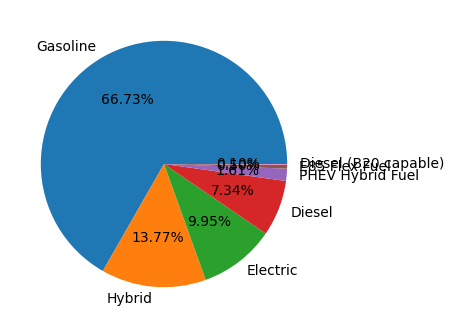

In [3]:
# Pie the cars Fuel Type 
plt.figure(figsize=(6,4))
plt.pie(df['fuel'].value_counts(), autopct="%1.2f%%" , labels=df['fuel'].value_counts().index)
plt.show()

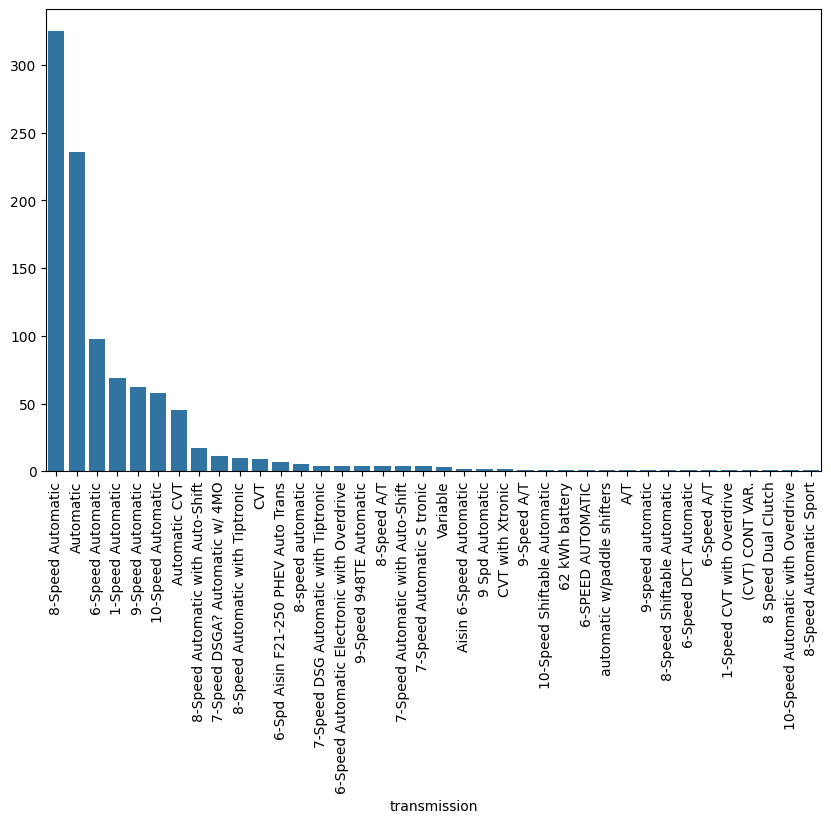

In [4]:
# Plotting the cars Fuel Type 
plt.figure(figsize=(10,6))
bar = sns.barplot(x=df['transmission'].value_counts().index,y=df['transmission'].value_counts().values)
plt.xticks(rotation=90)
plt.show()

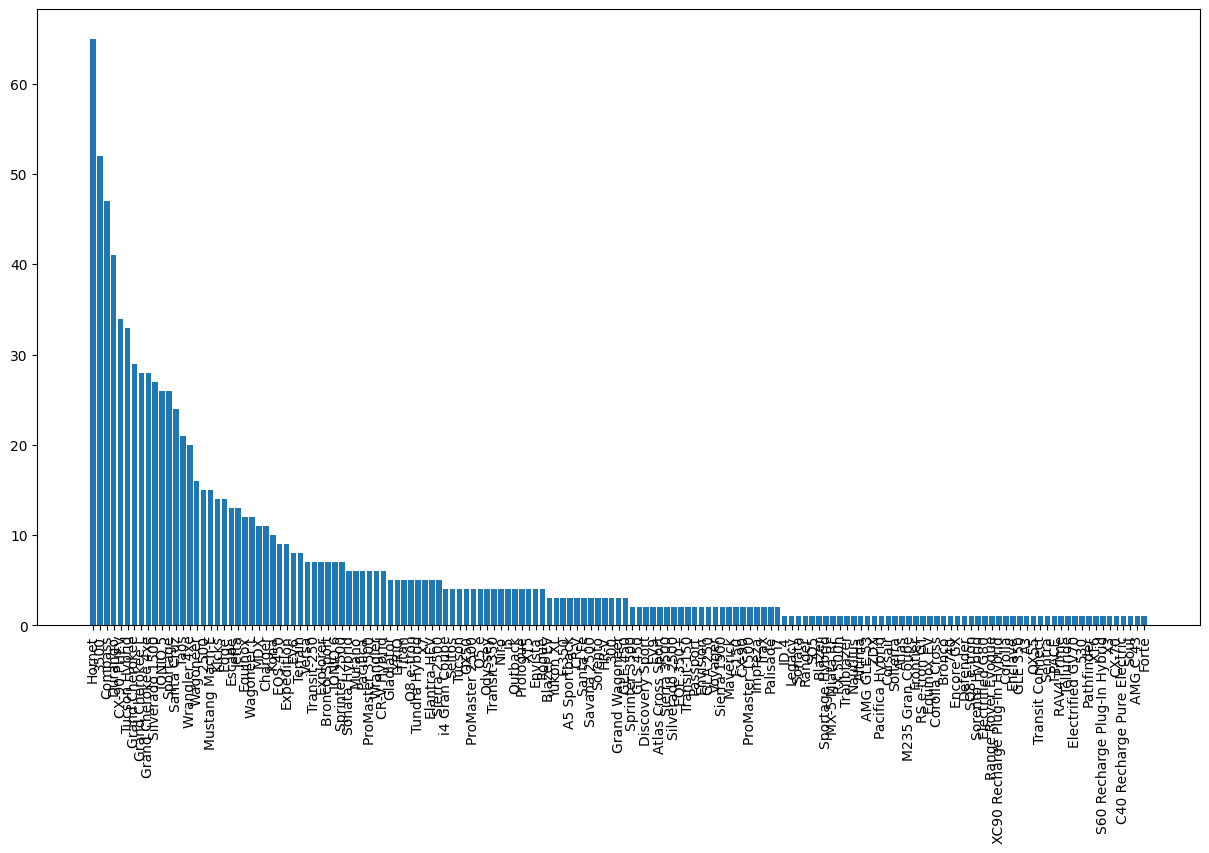

In [5]:
# Plotting the cars Models for each Brand
plt.figure(figsize=(15,8))
plt.bar(x=df['model'].value_counts().index,height=df['model'].value_counts().values)
plt.xticks(rotation=90)
plt.show()

In [6]:
# Average price of all vehicles
df['price'].mean()

np.float64(50202.98569969356)

In [7]:
# print the counts of Models of cars 
df['model'].value_counts()

model
Hornet                        65
3500                          52
Compass                       47
Durango                       41
CX-90 PHEV                    34
                              ..
CX-70                          1
C40 Recharge Pure Electric     1
Soul                           1
AMG C 43                       1
Forte                          1
Name: count, Length: 153, dtype: int64

# Data Preprocessing

In [8]:

# Filter out bad data
df = df[df['price'] > 1000]
df.dropna(subset=['make', 'model', 'fuel', 'transmission', 'price', 'mileage', 'year'], inplace=True)
# Feature engineering
df['vehicle_age'] = 2025 - df['year']
df['log_price'] = np.log1p(df['price'])
df['log_mileage'] = np.log1p(df['mileage'])
df['make_model'] = df['make'].str.strip().str.lower() + "_" + df['model'].str.strip().str.lower()
# Feature selection
selected_features = ["make", "model", "trim", "make_model", "log_mileage", "vehicle_age"]
X = df[selected_features]
y = df["log_price"]

In [9]:


# Define features
categorical_cols = ['make', 'model',  'trim', 'make_model' ,]
numerical_cols = ['vehicle_age', 'log_mileage',  ]
y = df['log_price']

# Apply one-hot encoding to categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat = encoder.fit_transform(df[categorical_cols])
X_cat_df = pd.DataFrame(X_cat, columns=encoder.get_feature_names_out(categorical_cols))

# 🧼 Clean column names for XGBoost compatibility
X_cat_df.columns = [col.replace('[', '_').replace(']', '').replace('<', '') for col in X_cat_df.columns]

# Combine with numeric data
X = pd.concat([X_cat_df.reset_index(drop=True), df[numerical_cols].reset_index(drop=True)], axis=1)


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled= scaler.fit_transform(X)
X_final = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)


# Save scaler if needed for deployment
joblib.dump(scaler, "standard_scaler.pkl")


['standard_scaler.pkl']

# Data Preparation

In [11]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Model Training and evaluation

In [12]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# Define all models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'Support Vector Regressor': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}


In [13]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

results = {}
best_rmse = float('inf')
best_model = None
best_model_name = ""

for name, model in models.items():
    try:
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))
        r2 = r2_score(np.exp(y_test), np.exp(y_pred))
        
        # Save results
        results[name] = {'RMSE': rmse, 'R2': r2}
        
        # Find best model
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_model_name = name
            
    except Exception as e:
        print(f"⚠️ Error training {name}: {e}")


  File "C:\Users\Frough\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Program Files\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Program Files\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Program Files\Python310\lib\subprocess.py", line 1440, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


In [14]:
print("\n📊 Model Performance Comparison (Real Price):\n")
for name, metrics in results.items():
    print(f"{name} -> RMSE: ${metrics['RMSE']:.2f}, R²: {metrics['R2']:.4f}")

print(f"\n✅ Best model: {best_model_name} with RMSE ${best_rmse:.2f}")
joblib.dump(best_model, "vehicle_price_model.pkl")


📊 Model Performance Comparison (Real Price):

Random Forest -> RMSE: $5175.58, R²: 0.9090
Gradient Boosting -> RMSE: $8220.73, R²: 0.7704
Linear Regression -> RMSE: $3964.44, R²: 0.9466
Support Vector Regressor -> RMSE: $6220.59, R²: 0.8685
K-Nearest Neighbors -> RMSE: $9608.11, R²: 0.6864
Decision Tree -> RMSE: $5629.39, R²: 0.8923
XGBoost -> RMSE: $4624.67, R²: 0.9273

✅ Best model: Linear Regression with RMSE $3964.44


['vehicle_price_model.pkl']

In [15]:
joblib.dump(encoder, "onehot_encoder.pkl")


['onehot_encoder.pkl']

In [16]:
joblib.dump(X_final.columns.tolist(), "feature_names.pkl")

['feature_names.pkl']

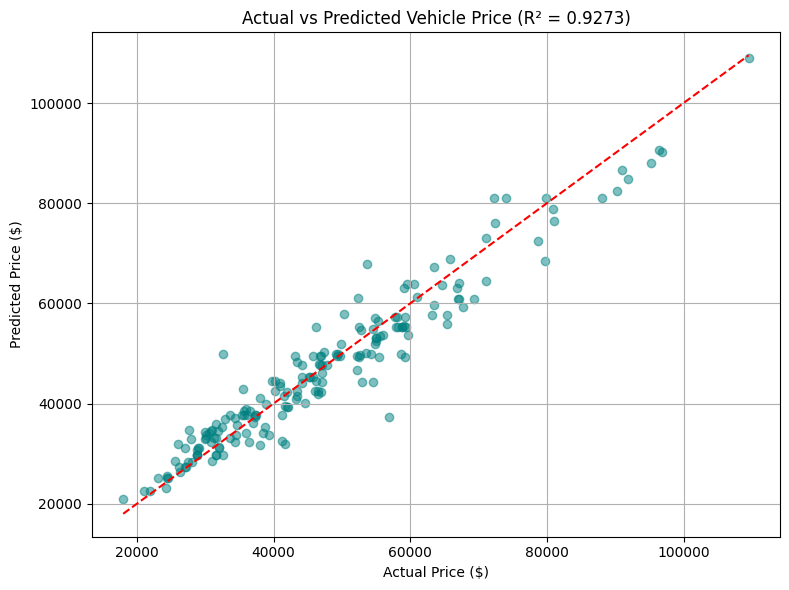

In [17]:
# Convert from log scale to original price scale
actual_price = np.expm1(y_test)
predicted_price = np.expm1(y_pred)

r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_price, predicted_price, alpha=0.5, color='teal')
plt.plot([actual_price.min(), actual_price.max()],
         [actual_price.min(), actual_price.max()], 'r--')
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title(f"Actual vs Predicted Vehicle Price (R² = {r2:.4f})")
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature Importance

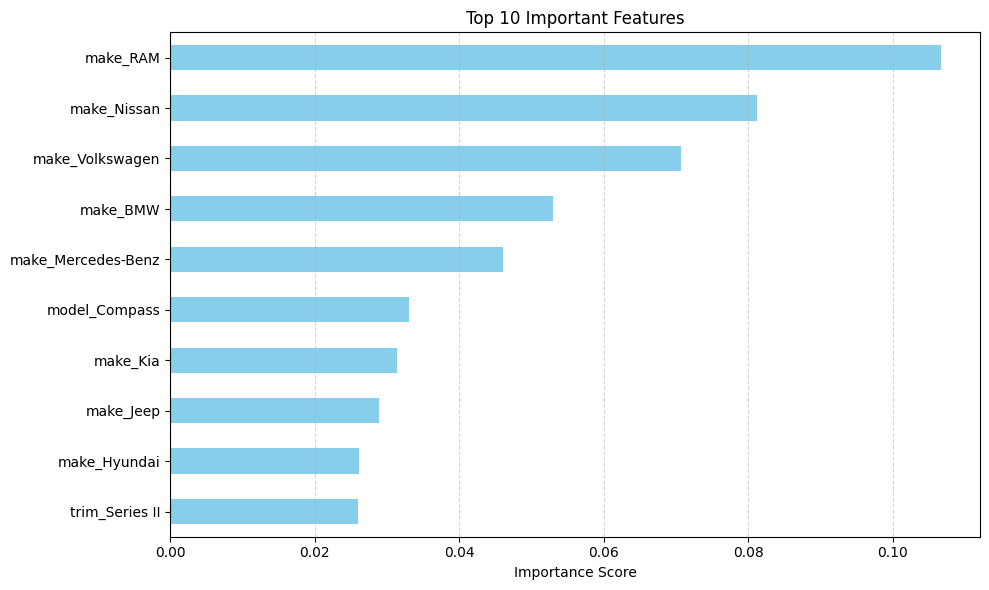

In [18]:

# Get feature importances from the trained XGBoost model
importances = model.feature_importances_
feature_names = X_final.columns  # Matches training input
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot top 10
plt.figure(figsize=(10, 6))
feature_importance.head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Important Features")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
